In [1]:
import flwr as fl 
import pandas as pd
import pickle
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import tasks as ts
import warnings
import argparse
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt




ModuleNotFoundError: No module named 'tasks'

In [14]:
# ts.__dict__

In [15]:
data_1 = pd.read_csv('../IID_df_1.csv')
data_2 = pd.read_csv('../IID_df_2.csv')

In [16]:
scaler = MinMaxScaler()
smote = SMOTE(random_state=422)


In [17]:
test = pd.read_csv('../test_glob.csv')

In [18]:

X_train_2, y_train_2 = data_2.drop(columns=["Fraud"]), data_2["Fraud"]





X_train_scale_2 = scaler.fit_transform(X_train_2)
X_train_2, y_train_2 = smote.fit_resample(X_train_scale_2, y_train_2)


X_test, y_test = test.drop(columns='Fraud'), test.Fraud 
X_test_scale = scaler.transform(X_test)

model = LogisticRegression(
max_iter=10
)

In [19]:


def plot_metrics(losses, ROC_AUC, ACCURACY, F1):
   
    rounds = list(range(1, len(losses) + 1))
    
    plt.figure(figsize=(12, 8))
  
    plt.subplot(2, 2, 1)
    plt.plot(rounds, losses, color='blue')
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(2, 2, 2)
    plt.plot(rounds, ROC_AUC, color='green')
    plt.title("ROC AUC over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("ROC AUC")

    plt.subplot(2, 2, 3)
    plt.plot(rounds, ACCURACY, color='orange')
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.subplot(2, 2, 4)
    plt.plot(rounds, F1, color='red')
    plt.title("F1 Score over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")

    plt.tight_layout()
    plt.show()





In [20]:
X_train, X_test, y_train, y_test = X_train_2, X_test_scale, y_train_2, y_test

In [ ]:
# data = pd.read_csv('../Non_IID_df_1.csv')

In [ ]:
# X_train, y_train = data.drop(columns='Fraud'), data.Fraud

# X_train_scale = scaler.fit_transform(X_train)
# X_train_, y_train_ = smote.fit_resample(X_train_scale, y_train)

In [12]:

from flwr.client.mod import fixedclipping_mod, adaptiveclipping_mod

In [73]:
class CustomClientDP(fl.client.NumPyClient):
  
    def __init__(self, model, X_train, X_test, y_train, y_test):
        self.model = model
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.losses = []
        self.ROC_AUCs = []
        self.ACCURACYs = []
        self.F1s = []

    def get_parameters(self, config):
         
        return ts.get_model_parameters(model)
    
    def fit(self, parameters, config):
        ts.set_model_parameters(model, parameters)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(X_train, y_train)
    
        
        return ts.get_model_parameters(model), len(X_train), {}

    def evaluate(self, parameters, config):
        
        ts.set_model_parameters(model, parameters)
        
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        
       
        loss = log_loss(y_test, y_pred_proba)
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        f1 = f1_score(y_test, y_pred)

        print(f'accuracy: {accuracy}')
        print(f'ROC_AUC: {roc_auc}')
        print(f'f1_score: {f1}')

        
        self.losses.append(loss)
        self.ROC_AUCs.append(roc_auc)
        self.ACCURACYs.append(accuracy)
        self.F1s.append(f1)
        
        
        return loss, len(X_test), {"accuracy": accuracy, "roc_auc": roc_auc, "f1-score": f1}


if __name__ == "__main__":
    N_CLIENTS = 2

    model = LogisticRegression(
        max_iter=1,
        warm_start=True
    )

    ts.set_initial_parameters(model)
    
    
    client_dp = CustomClientDP(model, X_train, X_test, y_train, y_test)

    
    fl.client.start_client(
        server_address="127.0.0.1:8080",
        client=client_dp
    )



INFO :      
INFO :      Received: get_parameters message e6882743-ad16-4611-91af-284751bae504
INFO :      Sent reply


INFO :      
INFO :      Received: train message 614e32d9-581d-4478-8f09-0d2450e8aa4b
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message cc160d22-ddeb-445f-b8f0-1ad27f88077d
INFO :      Sent reply
INFO :      
INFO :      Received: train message 2d10f96f-90fc-48f4-9e7e-dbfaa0e5c6de
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 4fe4fa88-a2a4-4af8-b354-2e95215ce7f0
INFO :      Sent reply
INFO :      
INFO :      Received: train message 39075427-3e30-4e56-90f7-4bca55921c84
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message c2704f83-fb24-4838-8e1e-916a483b5dea
INFO :      Sent reply
INFO :      
INFO :      Received: train message 93eda1fd-8776-47a5-96e3-fe0ffe5b3ff6
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 10e5d447-1d51-42b8-925a-73e1144ded52
INFO :      Sent reply
INFO :      
INFO :      Received: train message 2bad8f8f-16d4-4b27-a09a-2b36f9399cb2
INFO :      Sent reply
INFO : 

accuracy: 0.9393644617380026
ROC_AUC: 0.7620293847566574
f1_score: 0.050761421319796954
accuracy: 0.6961738002594033
ROC_AUC: 0.7599250076522804
f1_score: 0.2172096908939014
accuracy: 0.5732814526588845
ROC_AUC: 0.7578321089684726
f1_score: 0.1896551724137931
accuracy: 0.6780155642023347
ROC_AUC: 0.760189011325375
f1_score: 0.21127879269261318


INFO :      Sent reply
INFO :      
INFO :      Received: train message bcc24021-1bac-45fe-b519-403d736d99b4
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message aea00947-260a-47f0-be4e-126971eaf95f
INFO :      Sent reply
INFO :      
INFO :      Received: train message 1659aa42-5d02-4d03-9528-4bd2c8c8af10
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 3ddd6111-4676-41f7-be39-966604f5d400
INFO :      Sent reply
INFO :      
INFO :      Received: train message c83c41d0-c121-47e8-b1f9-f4987b198965
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 6bf7fee5-735f-4df9-949c-08edb6a83bdc
INFO :      Sent reply
INFO :      
INFO :      Received: train message 21cd7d13-0a6f-4cd6-b4b2-786974599e82
INFO :      Sent reply


accuracy: 0.5625810635538262
ROC_AUC: 0.7577517600244873
f1_score: 0.18685955394816153
accuracy: 0.6588845654993515
ROC_AUC: 0.7603803183348637
f1_score: 0.2054380664652568
accuracy: 0.7383268482490273
ROC_AUC: 0.7651572543617999
f1_score: 0.21726479146459748
accuracy: 0.646887159533074
ROC_AUC: 0.7640878481787573
f1_score: 0.2033650329188003


INFO :      
INFO :      Received: evaluate message 1be2b734-ac14-4840-ad6b-9beadda90fb2
INFO :      Sent reply
INFO :      
INFO :      Received: train message 30e93b90-0090-4351-9fb6-e4b027884a10
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 36c5d37e-a127-4a6f-a398-f8f919c532ff
INFO :      Sent reply
INFO :      
INFO :      Received: train message 9a816293-2209-4679-aecc-f3d70ff177db
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message ff6fa295-5b64-463c-8cb2-1b533bfd20d9
INFO :      Sent reply
INFO :      
INFO :      Received: train message 90d592ef-91d5-4877-afe5-893c15b3fc95
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 8675cb0b-a4b1-47c2-9e3c-50e535644e62
INFO :      Sent reply
INFO :      
INFO :      Received: train message 120ae3cd-03d3-49da-b202-5e421068f2cb
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message c26d4490-6146-4aed-b2c7-0d2d55cd779c
INFO :      Sent reply


accuracy: 0.6465629053177692
ROC_AUC: 0.7634507958371596
f1_score: 0.2055393586005831
accuracy: 0.6601815823605707
ROC_AUC: 0.7638774104683195
f1_score: 0.2096530920060332
accuracy: 0.6442931258106356
ROC_AUC: 0.7636038414447506
f1_score: 0.20449601160261058
accuracy: 0.6588845654993515
ROC_AUC: 0.7640648913376187
f1_score: 0.20902255639097744
accuracy: 0.6429961089494164
ROC_AUC: 0.7637530609121518
f1_score: 0.20505415162454874


INFO :      
INFO :      Received: train message 08af46d1-9845-45af-be61-c7e12b95b0c5
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 743c51d9-56d8-4273-be6e-ebf8f4cfe9b4
INFO :      Sent reply
INFO :      
INFO :      Received: train message cda572b7-468d-4886-bdef-683a4f721d83
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message f877c8bf-9e53-4bb7-81a3-2e7457b4b9f4
INFO :      Sent reply
INFO :      
INFO :      Received: train message 3f34bdf6-102c-4337-9f2a-60c8b410a0b7
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 01e9a3ed-ce48-46e0-aed7-36a498a85454
INFO :      Sent reply
INFO :      
INFO :      Received: train message 4400b34e-f6fb-4f78-b3b7-f8e934a7e727
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 6fbb02fb-b796-4e27-99e3-f321c56f6e9b
INFO :      Sent reply


accuracy: 0.6582360570687419
ROC_AUC: 0.7641930670339762
f1_score: 0.2087087087087087
accuracy: 0.6394293125810635
ROC_AUC: 0.7637874961738598
f1_score: 0.2057142857142857
accuracy: 0.6559662775616083
ROC_AUC: 0.7641873278236914
f1_score: 0.20761762509335324
accuracy: 0.6825551232166018
ROC_AUC: 0.7641892408937864
f1_score: 0.2085691188358933


INFO :      
INFO :      Received: train message 3e66a428-956b-4657-abf3-61c9f04d7ef9
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 11c543cf-f103-41bd-94f0-677576d09b31
INFO :      Sent reply
INFO :      
INFO :      Received: train message 23211576-85a5-4090-82ee-89ee46bec5b4
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 542762f4-c94e-4245-a0c8-b1295a527fb8
INFO :      Sent reply
INFO :      
INFO :      Received: train message 936df903-b507-489f-9ff9-8070575967d3
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 1c8ef404-4091-4ba2-b00c-f8d6c8db5a01
INFO :      Sent reply
INFO :      
INFO :      Received: train message 023b7745-3caf-4ded-a204-64a711de5a3b
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message df056ee4-3f12-49b9-bd04-338f264b53fe
INFO :      Sent reply
INFO :      
INFO :      Received: train message fe8cf1e8-23ee-476c-9ea5-7c3fd46c00e1
INFO :      Sent reply


accuracy: 0.6559662775616083
ROC_AUC: 0.7638410621365167
f1_score: 0.20524344569288389
accuracy: 0.6533722438391699
ROC_AUC: 0.7640495867768595
f1_score: 0.20638455827765403
accuracy: 0.6423476005188068
ROC_AUC: 0.7645603764921947
f1_score: 0.2059035277177826
accuracy: 0.6536964980544747
ROC_AUC: 0.7647880318334864
f1_score: 0.20771513353115728


INFO :      
INFO :      Received: evaluate message 8f087d94-ea42-4e11-918d-9e451661584a
INFO :      Sent reply
INFO :      
INFO :      Received: train message 5468c366-bb3d-4574-9308-db1428adc1a2
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message bd856445-b22b-4651-854d-12c0b41dd904
INFO :      Sent reply
INFO :      
INFO :      Received: train message 59634386-6c0d-4b00-81db-b4e5a150f664
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message be75811d-8fa2-4d07-be40-a015084c4307
INFO :      Sent reply
INFO :      
INFO :      Received: train message 6714bdf8-d67a-4bdd-8db7-0ce79536fc6d
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 36b94d70-8b7f-4137-8eb7-52d4828675d6
INFO :      Sent reply
INFO :      
INFO :      Received: train message a428bfc1-eb45-4eca-95e2-578605208003
INFO :      Sent reply


accuracy: 0.6536964980544747
ROC_AUC: 0.7648492500765227
f1_score: 0.20771513353115728
accuracy: 0.6511024643320363
ROC_AUC: 0.7648836853382307
f1_score: 0.20648967551622419
accuracy: 0.648508430609598
ROC_AUC: 0.7649257728803184
f1_score: 0.20760233918128654
accuracy: 0.643644617380026
ROC_AUC: 0.7649181205999389
f1_score: 0.20535068691250905


INFO :      
INFO :      Received: evaluate message e032ac04-412f-489f-b2a9-44c2f29ccb94
INFO :      Sent reply
INFO :      
INFO :      Received: train message 3c2fc7f4-c6d6-461f-8bb8-f311a65cbfc4
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message ff573687-2e52-465c-8dcb-fd62f79f98f5
INFO :      Sent reply
INFO :      
INFO :      Received: train message 04608a08-4bb5-4bfd-975f-4ef3a4501bfa
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 237c5507-ede6-437c-8257-bf9059f8bb68
INFO :      Sent reply
INFO :      
INFO :      Received: train message a216ed0b-d692-49d8-b11b-a65e286c3cbd
INFO :      Sent reply
INFO :      


accuracy: 0.6543450064850843
ROC_AUC: 0.7652203856749311
f1_score: 0.20684523809523808
accuracy: 0.6446173800259404
ROC_AUC: 0.7651591674318946
f1_score: 0.20579710144927535
accuracy: 0.6326199740596627
ROC_AUC: 0.7657388276706458
f1_score: 0.2037947997189037


INFO :      Received: evaluate message 5e1f3586-9619-4736-8f91-77c1ee2ab17f
INFO :      Sent reply
INFO :      
INFO :      Received: train message b8231bc9-8635-4b56-b23d-c6ba023f8ffd
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 4476b816-584c-4896-96f4-bfb24fd7dcdc
INFO :      Sent reply
INFO :      
INFO :      Received: train message e66c2bd0-ac66-46e1-9357-12031f3624f7
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 11bb41fc-6ab0-4308-bb96-c8941e5c9141
INFO :      Sent reply
INFO :      
INFO :      Received: train message a0c6698e-6280-41d8-9239-113c46f60d1f
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 4c39967e-e07e-41db-9bd7-7e97c89a1494
INFO :      Sent reply
INFO :      
INFO :      Received: train message 0f618b18-b221-4f20-9558-00a35a446e7b
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 0128f91a-58a8-4960-a75a-b8208bcdd0d0
INFO :      Sent reply
INFO :      
INFO

accuracy: 0.6416990920881972
ROC_AUC: 0.7658861340679523
f1_score: 0.20674802584350324
accuracy: 0.6433203631647212
ROC_AUC: 0.7660410927456381
f1_score: 0.20634920634920634
accuracy: 0.646887159533074
ROC_AUC: 0.7661348331802877
f1_score: 0.20452885317750183
accuracy: 0.6410505836575876
ROC_AUC: 0.7660353535353535
f1_score: 0.2064516129032258
accuracy: 0.6488326848249028
ROC_AUC: 0.7670167584940313
f1_score: 0.20542920029347028


INFO :      Received: evaluate message d5a0bc93-fdf9-4128-883f-bddac99f84ab
INFO :      Sent reply
INFO :      
INFO :      Received: train message be9ed656-5536-49cb-b796-b46097ed434e
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message a51ed091-e4b5-40d3-953a-02cea72be467
INFO :      Sent reply
INFO :      
INFO :      Received: train message 5ef7980a-d6f7-4804-9d94-a801178cf75d
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message d09765c3-778b-482e-9546-cde93a0880e0
INFO :      Sent reply
INFO :      
INFO :      Received: train message 31c253bc-f1c0-4c1d-b8b1-b64e744660fa
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 4124de92-a5c8-4480-9c0a-e6d0d18649b9
INFO :      Sent reply
INFO :      
INFO :      Received: train message b5cab7ae-953b-4b5a-8975-05b82e3e0123
INFO :      Sent reply


accuracy: 0.6371595330739299
ROC_AUC: 0.7668177992041629
f1_score: 0.2046908315565032
accuracy: 0.6384565499351491
ROC_AUC: 0.76694980104071
f1_score: 0.2052744119743407
accuracy: 0.6404020752269779
ROC_AUC: 0.7670607591062136
f1_score: 0.20615604867573373
accuracy: 0.6501297016861219
ROC_AUC: 0.7672520661157025
f1_score: 0.20486366985998525


INFO :      
INFO :      Received: evaluate message 2c8064e1-2539-49b7-93df-de15e29b1b2b
INFO :      Sent reply
INFO :      
INFO :      Received: train message c37ea8f7-58d9-4333-bff0-2375688eb179
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 237610a0-b30a-4843-83ba-2202bfc7e3b6
INFO :      Sent reply
INFO :      
INFO :      Received: train message fd9f7b3d-b3cd-4a85-a8ab-9be174f46359
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 2af952f1-b2c4-4029-9141-5f93ef305e18
INFO :      Sent reply
INFO :      
INFO :      Received: train message e83c1658-00c4-45c3-888a-be819ce3ff89
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 5ec58533-cec0-4bf0-a0a5-87249f01dfc5
INFO :      Sent reply
INFO :      
INFO :      Received: train message 58acc0e6-6bc1-4f47-8b68-a31728af91ec
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 4682726d-48c5-41ac-a4e6-644bdfd6496e
INFO :      Sent reply
INFO

accuracy: 0.6400778210116731
ROC_AUC: 0.7671487603305784
f1_score: 0.20373027259684362
accuracy: 0.6384565499351491
ROC_AUC: 0.7671391949801041
f1_score: 0.2052744119743407
accuracy: 0.6316472114137484
ROC_AUC: 0.7673974594429139
f1_score: 0.20336605890603085
accuracy: 0.6394293125810635
ROC_AUC: 0.7675868533823079
f1_score: 0.2034383954154728
accuracy: 0.6416990920881972
ROC_AUC: 0.7676595500459137
f1_score: 0.20331651045421772
accuracy: 0.6345654993514915
ROC_AUC: 0.767516069788797
f1_score: 0.20353356890459365


INFO :      
INFO :      Received: train message 59cea1ea-2049-48d8-ac99-cc421caec093
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 7bca2c76-96b0-4ef0-b357-39cad67332ae
INFO :      Sent reply
INFO :      
INFO :      Received: train message 4cfe168c-67cb-4d74-ad00-a83f2b4df34d
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message fa88675c-239d-4b32-8f69-1f402b2fe8a2
INFO :      Sent reply
INFO :      
INFO :      Received: train message e8c5a178-0d81-4993-ad08-22c55b359576
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 4e533b47-e51d-4fe8-9ac8-f3cfc1c2c973
INFO :      Sent reply
INFO :      
INFO :      Received: train message a8a3344e-0953-4bf4-a8a5-5b996c26bdde
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 0f642e9f-3e33-4879-9d26-923e5785b05c
INFO :      Sent reply
INFO :      
INFO :      Received: train message 1f732eb4-189f-4e21-b8a7-0c47db3600f3
INFO :      Sent reply
INFO : 

accuracy: 0.6404020752269779
ROC_AUC: 0.7675734618916437
f1_score: 0.20273184759166069
accuracy: 0.642023346303502
ROC_AUC: 0.7675983318028774
f1_score: 0.20346320346320346
accuracy: 0.6605058365758755
ROC_AUC: 0.7663720538720539
f1_score: 0.20621683093252463
accuracy: 0.6498054474708171
ROC_AUC: 0.7663624885215794
f1_score: 0.20353982300884957
accuracy: 0.6449416342412452
ROC_AUC: 0.7664409243954697
f1_score: 0.202476329206118


INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message c8b71d4e-8a53-4f83-aa84-64fc28a3503e
INFO :      Sent reply
INFO :      
INFO :      Received: train message 35d42b2b-f688-4d71-98ed-42aeffbf4b56
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message d571c45c-c680-4a74-8aef-24b606db05c6
INFO :      Sent reply
INFO :      
INFO :      Received: reconnect message 3aa004b7-1bc5-4947-bacb-57dcaf39058d
INFO :      Disconnect and shut down


accuracy: 0.6579118028534371
ROC_AUC: 0.7668082338536885
f1_score: 0.20736288504883546
accuracy: 0.6465629053177692
ROC_AUC: 0.7666972757881849
f1_score: 0.20321637426900585


---

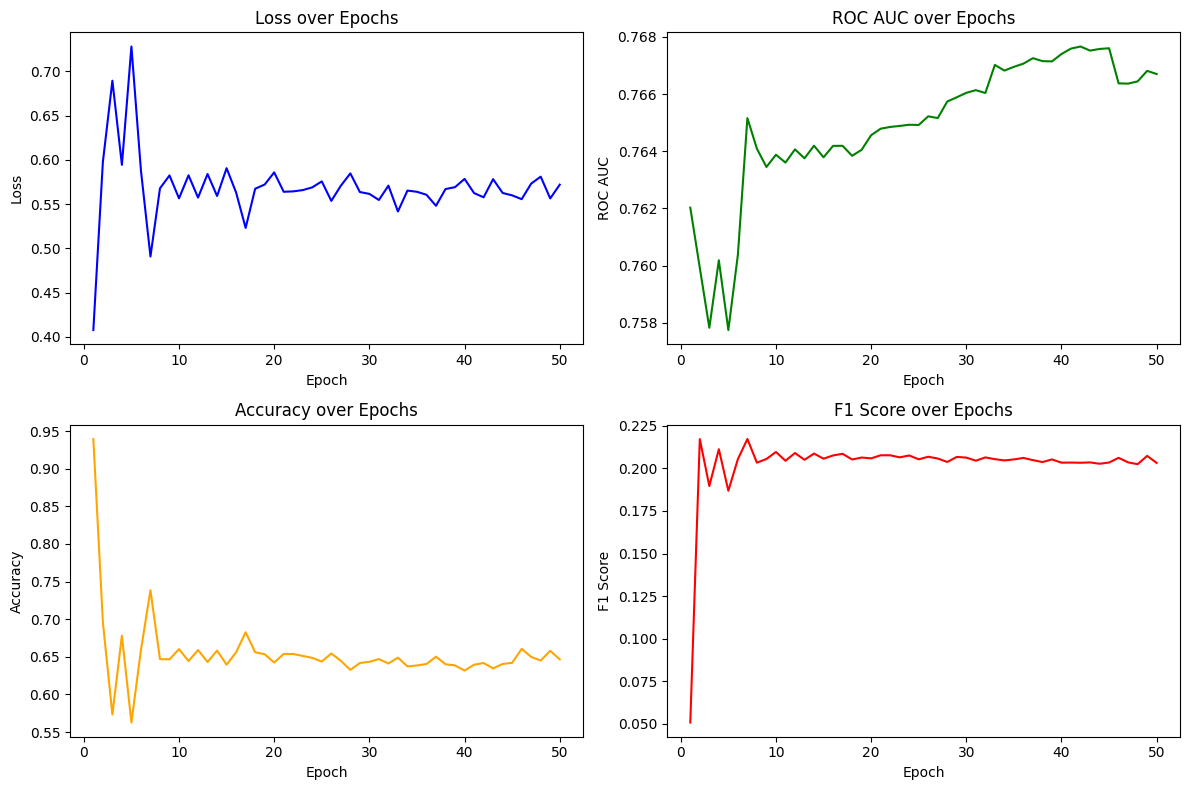

In [74]:
L, ROC_AUC, ACCURACY, F1 = client_dp.losses, client_dp.ROC_AUCs, client_dp.ACCURACYs, client_dp.F1s

plot_metrics(L, ROC_AUC, ACCURACY, F1)

In [46]:
L_dp_fixed, ROC_AUC_dp_fixed, ACCURACY_dp_fixed, F1_dp_fixed = L, ROC_AUC, ACCURACY, F1 

In [49]:
L_dp_adap, ROC_AUC_dp_adap, ACCURACY_dp_adap, F1_dp_adap = L, ROC_AUC, ACCURACY, F1 

In [75]:
L_fedavg, ROC_AUC_fedavg, ACCURACY_fedavg, F1_fedavg = L, ROC_AUC, ACCURACY, F1



In [76]:
L_fedavg == L_dp_fixed

False

In [71]:
def plot_metrics_comparison_simple(L_1, ROC_AUC_1, ACCURACY_1, F1_1, 
                                   L_2, ROC_AUC_2, ACCURACY_2, F1_2,
                                   L_3, ROC_AUC_3, ACCURACY_3, F1_3,
                                   L_4, ROC_AUC_4, ACCURACY_4, F1_4):
    rounds = list(range(1, len(L_1) + 1))
    
    plt.figure(figsize=(12, 8))
  

    plt.subplot(2, 2, 1)
    plt.plot(rounds, L_1, color='blue', label='FedAvg')
    plt.plot(rounds, L_2, color='orange', label='DP_fixed')
    plt.plot(rounds, L_3, color='green', label='DP_Adaptive')
    plt.plot(rounds, L_4, color='red', label='FedAvg_Paillier')
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(rounds, ROC_AUC_1, color='blue', label='FedAvg')
    plt.plot(rounds, ROC_AUC_2, color='orange', label='DP_fixed')
    plt.plot(rounds, ROC_AUC_3, color='green', label='DP_Adaptive')
    plt.plot(rounds, ROC_AUC_4, color='red', label='FedAvg_Paillier')
    plt.title("ROC AUC over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("ROC AUC")
    plt.legend()

    
    plt.subplot(2, 2, 3)
    plt.plot(rounds, ACCURACY_1, color='blue', label='FedAvg')
    plt.plot(rounds, ACCURACY_2, color='orange', label='DP_fixed')
    plt.plot(rounds, ACCURACY_3, color='green', label='DP_Adaptive')
    plt.plot(rounds, ACCURACY_4, color='red', label='FedAvg_Paillier')
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

 
    plt.subplot(2, 2, 4)
    plt.plot(rounds, F1_1, color='blue', label='FedAvg')
    plt.plot(rounds, F1_2, color='orange', label='DP_fixed')
    plt.plot(rounds, F1_3, color='green', label='DP_Adaptive')
    plt.plot(rounds, F1_4, color='red', label='FedAvg_Paillier')
    plt.title("F1 Score over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.legend()

    plt.tight_layout()
    plt.show()




In [ ]:



import flwr as fl 
import pandas as pd
import pickle
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import tasks as ts
import warnings
import argparse
import numpy as np
import logging
import datetime
import os 

In [39]:
# LOG_PATH = os.path.join("tests1", f"results_{datetime.now()}.txt")

# logging.basicConfig(filename=LOG_PATH, level=logging.INFO)
# logging.exception("EXCEPTION OCCURED")


class CustomClient(fl.client.NumPyClient):

        
    def __init__(self, model, X_train, X_test, y_train, y_test):
        self.model = model
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.losses = []
        self.ROC_AUCs = []
        self.ACCURACYs = []
        self.F1s = []


        with open('../public_key.pkl', 'rb') as f:
            self.__public_key = pickle.load(f)

        with open('../private_key.pkl', 'rb') as f:
            self.__private_key = pickle.load(f)


    def get_parameters(self, config):

        print('================== INITIAL PARAMS ==================')
        params = ts.get_model_parameters(model)
        encrypted_params = [(self.__public_key.encrypt(value),) for param in params for value in param.flatten()]
        enc_result = []
        index = 0

        for param in params:
                num_elements = param.size
                reshaped_array = np.array(encrypted_params[index:index + num_elements]).reshape(param.shape)
                enc_result.append(reshaped_array)
                index += num_elements

        print(params)

        return enc_result

    def fit(self, parameters, config):
        
        
        
        print('============================ PARAMS BEFORE  FIT===========================')
        print(parameters)
        
        decrypted_params = [(self.__private_key.decrypt(value),) for param in parameters for value in param.flatten()]
        dec_res = []
        index = 0
        for param in parameters:
               num_elements = param.size
               reshaped_array = np.array(decrypted_params[index:index + num_elements]).reshape(param.shape)
               dec_res.append(reshaped_array)
               index += num_elements

        ts.set_model_parameters(model, dec_res)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(X_train, y_train)
        print(f"Training finished for round {config['server_round']}")
        print('============================= PARAMETERS AFTER FIT ===============================')
        params_1 = ts.get_model_parameters(model)
        print(f'clear: {params_1}')
        encrypted_params = [(self.__public_key.encrypt(value),) for param in params_1 for value in param.flatten()]
        enc_result = []
        index = 0

        for param in params_1:
                num_elements = param.size
                reshaped_array = np.array(encrypted_params[index:index + num_elements]).reshape(param.shape)
                enc_result.append(reshaped_array)
                index += num_elements
            # encrypt parameters here


        print(f'Encrypted: {enc_result}')
        
        return enc_result, len(X_train), {}

    def evaluate(self, parameters, config):
        print('========================== evaluate PARAMS =============================================')
        # i got agg parameters for server, here i have to decrypt them
        print(parameters, parameters[0].size, parameters[1].size)
        decrypted_params = [(self.__private_key.decrypt(value),) for param in parameters for value in param.flatten()]
        dec_res = []
        index = 0
        for param in parameters:
               num_elements = param.size
               reshaped_array = np.array(decrypted_params[index:index + num_elements]).reshape(param.shape)
               dec_res.append(reshaped_array)
               index += num_elements
        print(f' Decrypted for EVAL {dec_res}')


        
        ts.set_model_parameters(model, dec_res)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        loss = log_loss(y_test, y_pred_proba)
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        f1 = f1_score(y_test, y_pred)
        print(f'accuracy: {accuracy}')
        print(f'ROC_AUC: {roc_auc}')
        print(f'f1_score: {f1}')
        self.losses.append(loss)
        self.ROC_AUCs.append(roc_auc)
        self.ACCURACYs.append(accuracy)
        self.F1s.append(f1)
        
        return loss, len(X_test), {"accuracy": accuracy, "roc_auc": roc_auc, "f1-score": f1}

if __name__ == "__main__":

    model = LogisticRegression(
        
        max_iter=1,
        warm_start=True
    )



    ts.set_initial_parameters(model)
    client_paill = CustomClient(model, X_train, X_test, y_train, y_test)
    fl.client.start_client(
        server_address="127.0.0.1:8080",
        client=client_paill
    )



INFO :      
INFO :      Received: get_parameters message 106550a1-be74-4ef3-b5cc-32d3c742865b


================== INITIAL PARAMS ==================


INFO :      Sent reply
INFO :      
INFO :      Received: train message 4df62148-9cf0-42b2-9fe6-ad0910604542


[array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]]), array([0.])]
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512BB80>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512EC20>],
      dtype=object)]
Training finished for round 1
============================= PARAMETERS AFTER FIT ===============================
clear: [array([[-4.39520118e-02, -4.94452864e-02, -6.87200648e-02,
        -8.81334124e-02, -7.64466791e-02,  5.43694916e-02,
        -8.19209966e-02, -3.00138760e-03,  2.10840073e-01,
        -1.80182279e-02, -8.22151147e-02, -5.74585683e-01,
        -6.71071985e-02, -2.65962553e-01,  9.13177174e-02,
        -6.60401510e-02,  4.96981409e-02, -1.14521284e-02,
         4.78860164e-02,  2.81303462e-03, -5.54664466e-04,
        -2.65126517e-01, -8.98509592e

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537512B3A0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512E0B0>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message 6e000432-37ff-4ff1-8779-115dccbdb433


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512E740>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512FD60>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message 4b342daf-c3bf-42b5-a1b7-cc8c7a3c1c0a


 Decrypted for EVAL [array([[-0.04035642, -0.06838285, -0.04901064, -0.08041477, -0.05967494,
         0.0137327 , -0.05450042, -0.0270502 ,  0.1934429 , -0.01912221,
        -0.06654014, -0.60300138, -0.08105414, -0.28374685,  0.08911177,
        -0.06062822, -0.00356938,  0.00323606,  0.0363628 , -0.00799729,
        -0.00237556, -0.21984822, -0.07152266, -0.0411051 , -0.00924902,
        -0.03192408, -0.15789523, -0.01266152, -0.00180927, -0.0951876 ,
        -0.60414156,  0.        ,  0.0384818 ]]), array([2.60270951e-16])]
accuracy: 0.9393644617380026
ROC_AUC: 0.7620293847566574
f1_score: 0.050761421319796954
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512E980>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512C370>],
      dtype=object)]
Training finished for round 2
============================= PARAMETERS AFTER FIT ===============================
clear: [a

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537512D810>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512CCA0>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message cb10bf35-e2cc-44b4-85e5-5b6d5176f826


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x0000015375134850>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512D330>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message 6da0d8bb-a68a-4fa1-974f-471240dd77f4


 Decrypted for EVAL [array([[-7.85227898e-03, -4.17707323e-02, -1.91214947e-02,
        -4.68831425e-02, -1.90628792e-03,  5.21942515e-02,
        -2.11484043e-02,  5.19785659e-04,  2.57929707e-01,
         8.72419232e-03, -3.66387358e-02, -6.13455471e-01,
        -7.31566266e-02, -2.83023700e-01,  1.17188430e-01,
        -2.84628635e-02,  2.99157166e-02,  2.14344271e-02,
         7.10567916e-02,  5.77934196e-02,  6.40008794e-02,
        -2.01918279e-01, -2.11930701e-02, -4.14006940e-02,
        -9.35137251e-03, -3.24118580e-02, -1.40197553e-01,
        -9.49114285e-03, -8.86065331e-04, -6.86182400e-02,
        -5.95595052e-01,  0.00000000e+00,  7.71857798e-02]]), array([0.06662606])]
accuracy: 0.6961738002594033
ROC_AUC: 0.7599250076522804
f1_score: 0.2172096908939014
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x00000153751348B0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x00000

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537512BA90>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512D750>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message 2ef0744b-1337-4a6a-91cf-6bb8a1271fa8


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512F100>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512CAF0>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message 0279f587-5eaf-4401-8593-b7e83ab27dc6


 Decrypted for EVAL [array([[ 0.0056272 , -0.03793276, -0.0147556 , -0.0449453 ,  0.02195534,
         0.07819643, -0.01322053,  0.01561649,  0.32956273,  0.02157782,
        -0.03506377, -0.74108241, -0.07763452, -0.33640715,  0.15063013,
        -0.014663  ,  0.05381552,  0.03375694,  0.09792852,  0.09797477,
         0.10527437, -0.22685802, -0.00544354, -0.05064858, -0.01120123,
        -0.03953275, -0.1532137 , -0.00822571, -0.00074346, -0.06449341,
        -0.70110355,  0.        ,  0.1065705 ]]), array([0.10860449])]
accuracy: 0.5732814526588845
ROC_AUC: 0.7578321089684726
f1_score: 0.1896551724137931
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512E350>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512DB10>],
      dtype=object)]
Training finished for round 4
============================= PARAMETERS AFTER FIT ===============================
clear: [array([

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537512EDA0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x00000153749AF2B0>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message a39be024-0db7-43af-acab-7ed9bdd37296


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512ECB0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537505E1A0>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message 5c03d8b0-e5fb-4703-9d0d-122eb88a7162


 Decrypted for EVAL [array([[-6.73279184e-03, -4.99485331e-02, -2.77008550e-02,
        -6.02086087e-02,  2.53143075e-04,  6.52054614e-02,
        -2.67373422e-02,  5.59378348e-03,  3.14565949e-01,
         1.12493045e-02, -4.86790943e-02, -7.65184439e-01,
        -8.23616569e-02, -3.48924236e-01,  1.44769448e-01,
        -2.64969863e-02,  4.24984203e-02,  2.82173482e-02,
         8.71432650e-02,  7.57528032e-02,  8.31809395e-02,
        -2.39813325e-01, -2.53505692e-02, -5.27900409e-02,
        -1.16723890e-02, -4.09622437e-02, -1.63425740e-01,
        -9.40677107e-03, -1.13265180e-03, -7.57211625e-02,
        -7.28537691e-01,  0.00000000e+00,  9.50582856e-02]]), array([0.08658671])]
accuracy: 0.6780155642023347
ROC_AUC: 0.760189011325375
f1_score: 0.21127879269261318
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512FD60>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x00000

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537512C340>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510FEB0>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message 033759f5-3bbe-4d51-8253-9280879a6f50


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512E650>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512BC40>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message 4574e8c8-2209-4cc3-bd67-63285a328ffa


 Decrypted for EVAL [array([[ 0.01663888, -0.05232676, -0.04042313, -0.08225786,  0.03427222,
         0.12854815, -0.03113358,  0.04268516,  0.49802892,  0.03290438,
        -0.07107545, -1.16035048, -0.09401686, -0.51734038,  0.23125132,
        -0.00386827,  0.1084712 ,  0.05273835,  0.1525588 ,  0.16186754,
         0.17026304, -0.33703837, -0.01532004, -0.08125098, -0.01634824,
        -0.06357838, -0.2227828 , -0.00512621, -0.00158977, -0.08290999,
        -1.06647853,  0.        ,  0.15722973]]), array([0.17559479])]
accuracy: 0.5625810635538262
ROC_AUC: 0.7577517600244873
f1_score: 0.18685955394816153
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512BFD0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512C910>],
      dtype=object)]
Training finished for round 6
============================= PARAMETERS AFTER FIT ===============================
clear: [array(

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537512B250>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512E0E0>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message 80cf2e03-a322-4545-9937-92a7bf68b155


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512C670>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512DFF0>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message 7ec6e486-e650-4aa0-bea8-2f1b00ab25ef


 Decrypted for EVAL [array([[-0.00180861, -0.0694145 , -0.05906756, -0.10380939,  0.00165529,
         0.10762079, -0.05085769,  0.02734528,  0.4689547 ,  0.01713233,
        -0.09048412, -1.17987338, -0.09951302, -0.52882866,  0.21941543,
        -0.02143813,  0.09037411,  0.04381034,  0.13454954,  0.1268433 ,
         0.13526831, -0.35165097, -0.0447364 , -0.08333289, -0.01680132,
        -0.06485534, -0.23494434, -0.00671378, -0.00215413, -0.09863901,
        -1.09245891,  0.        ,  0.13794082]]), array([0.14064353])]
accuracy: 0.6588845654993515
ROC_AUC: 0.7603803183348637
f1_score: 0.2054380664652568
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512EBF0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512E140>],
      dtype=object)]
Training finished for round 7
============================= PARAMETERS AFTER FIT ===============================
clear: [array([

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537512DA80>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510EC80>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message 7fa245a3-1ea7-41f4-a521-4e9c6b9be008


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512E8C0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512C1C0>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message b0c172cd-bbe9-4709-9e1a-3a5846c1ef93


 Decrypted for EVAL [array([[-2.01202673e-02, -1.27329048e-01, -9.23496618e-02,
        -1.48880958e-01, -1.11016335e-02,  6.40775563e-02,
        -5.70332399e-02, -1.36111196e-03,  5.21493194e-01,
        -7.36718642e-04, -1.35615364e-01, -1.60424289e+00,
        -1.08990224e-01, -7.07143620e-01,  2.64153148e-01,
        -2.89314288e-04,  4.67419901e-02,  7.41003176e-02,
         1.13324995e-01,  1.25102769e-01,  1.47382006e-01,
        -3.53816202e-01, -6.00409941e-02, -1.31138621e-01,
        -3.04659374e-02, -9.29234174e-02, -2.05492449e-01,
        -1.48315626e-03, -2.34431249e-03, -8.40454340e-02,
        -1.39355450e+00,  0.00000000e+00,  1.71785211e-01]]), array([0.15735525])]
accuracy: 0.7383268482490273
ROC_AUC: 0.7651572543617999
f1_score: 0.21726479146459748
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512E6E0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x0000

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537512CC70>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510F310>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message 553f7392-9d11-41ee-8655-3ed5661dd792


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537510F6A0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512E8C0>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message 66426533-d078-4ac0-8e57-e0e8321b595c


 Decrypted for EVAL [array([[-7.02338387e-03, -1.16904985e-01, -8.11478859e-02,
        -1.36242683e-01,  1.18888812e-02,  7.91592344e-02,
        -4.38908138e-02,  9.98532603e-03,  5.46876268e-01,
         1.00608376e-02, -1.24729111e-01, -1.61168302e+00,
        -1.04561850e-01, -7.08337610e-01,  2.75519400e-01,
         1.29188783e-02,  6.02434083e-02,  8.19137958e-02,
         1.26999756e-01,  1.51484111e-01,  1.74159894e-01,
        -3.45838744e-01, -4.02202882e-02, -1.31943141e-01,
        -3.06616972e-02, -9.35383433e-02, -1.97957176e-01,
         3.19695779e-04, -1.99668377e-03, -7.34186437e-02,
        -1.39136129e+00,  0.00000000e+00,  1.87275456e-01]]), array([0.18433415])]
accuracy: 0.646887159533074
ROC_AUC: 0.7640878481787573
f1_score: 0.2033650329188003
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512EE90>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537512DFF0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512B5B0>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message 08ee7013-1702-4ff6-a134-cda27cc9c601


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512DB10>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512DE10>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message d83c07c5-49bc-482b-a039-b339e950e2aa


 Decrypted for EVAL [array([[ 0.01404171, -0.12319019, -0.12710803, -0.1976416 ,  0.01385112,
         0.12889743, -0.075693  ,  0.05998021,  0.66313385,  0.01053424,
        -0.19356608, -1.95259916, -0.07333851, -0.87211498,  0.33642556,
         0.01405458,  0.1313793 ,  0.10332057,  0.18720232,  0.20526937,
         0.22715318, -0.4390003 , -0.07458539, -0.16634563, -0.03513968,
        -0.12099723, -0.27249542,  0.0232379 , -0.00382106, -0.11476176,
        -1.68592862,  0.        ,  0.21225384]]), array([0.24115875])]
accuracy: 0.6465629053177692
ROC_AUC: 0.7634507958371596
f1_score: 0.2055393586005831
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512E830>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512BB80>],
      dtype=object)]
Training finished for round 10
============================= PARAMETERS AFTER FIT ===============================
clear: [array(

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537512FDF0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510FC40>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message 4f5ef885-9a4d-4f3e-aa1b-e76fdb43a06c


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512DB10>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510F4C0>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message a7735184-b838-4f37-ab4d-5b9377195c0f


 Decrypted for EVAL [array([[ 0.00982413, -0.12873584, -0.13247257, -0.20369079,  0.00695336,
         0.12233321, -0.07997263,  0.05602542,  0.65663025,  0.00619169,
        -0.20030799, -1.97018572, -0.0719172 , -0.88042788,  0.33490467,
         0.01248221,  0.12596193,  0.1034413 ,  0.18140793,  0.19819175,
         0.22079349, -0.43863872, -0.08093875, -0.16924386, -0.03587634,
        -0.12266587, -0.27173382,  0.0240351 , -0.0039883 , -0.11635017,
        -1.69788433,  0.        ,  0.2091104 ]]), array([0.23512664])]
accuracy: 0.6601815823605707
ROC_AUC: 0.7638774104683195
f1_score: 0.2096530920060332
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512FC40>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510DC30>],
      dtype=object)]
Training finished for round 11
============================= PARAMETERS AFTER FIT ===============================
clear: [array(

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537512D7B0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510F190>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message c3776b8b-f2b2-45d2-a96c-5183ba54a314


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537510EDA0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512BB20>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message e8aa932a-c75e-46ac-a757-7f1e20703c25


 Decrypted for EVAL [array([[ 0.01550734, -0.12688812, -0.13142377, -0.20299874,  0.01475046,
         0.1275438 , -0.07726778,  0.06156561,  0.66806184,  0.00882642,
        -0.20155812, -1.9918098 , -0.06642488, -0.89021727,  0.34063271,
         0.01890826,  0.13243443,  0.10799469,  0.18706935,  0.20913216,
         0.23206367, -0.43655843, -0.07606972, -0.17223212, -0.03645788,
        -0.1247678 , -0.2688934 ,  0.02662921, -0.00399921, -0.11282407,
        -1.70966132,  0.        ,  0.2145697 ]]), array([0.24684494])]
accuracy: 0.6442931258106356
ROC_AUC: 0.7636038414447506
f1_score: 0.20449601160261058
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537505E230>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512DD20>],
      dtype=object)]
Training finished for round 12
============================= PARAMETERS AFTER FIT ===============================
clear: [array

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537512B400>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512E050>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message 9d69de0c-075c-4b06-8351-f417af046416


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512C040>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512C7F0>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message 14b34b6a-fad5-47ee-b524-7ccb4a755e43


 Decrypted for EVAL [array([[ 0.01141623, -0.13212558, -0.13655307, -0.20879979,  0.00798331,
         0.12130776, -0.08146891,  0.05777713,  0.66161361,  0.00461835,
        -0.208024  , -2.00760216, -0.06505751, -0.89784386,  0.33902498,
         0.01714414,  0.12726919,  0.10799404,  0.18154835,  0.20217207,
         0.2257598 , -0.43643753, -0.08229365, -0.17490454, -0.03713133,
        -0.12631191, -0.26848792,  0.02737864, -0.00416573, -0.11463534,
        -1.72061909,  0.        ,  0.21137687]]), array([0.24084821])]
accuracy: 0.6588845654993515
ROC_AUC: 0.7640648913376187
f1_score: 0.20902255639097744
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512C370>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512E710>],
      dtype=object)]
Training finished for round 13
============================= PARAMETERS AFTER FIT ===============================
clear: [array

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537512CC70>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510FFD0>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message ec28ee0c-1e86-4cef-ba8c-96efabcf3355


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512E3B0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510DBD0>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message 87b59b12-18c1-4ba6-89ef-9e1315551ce3


 Decrypted for EVAL [array([[ 0.01777676, -0.13037644, -0.13613221, -0.20907511,  0.01597337,
         0.12716567, -0.07931293,  0.06426762,  0.67432742,  0.00710516,
        -0.21063817, -2.03334177, -0.05828359, -0.91002696,  0.34535545,
         0.02383537,  0.13492791,  0.11302071,  0.18822022,  0.21404868,
         0.23791743, -0.43527277, -0.07795302, -0.17848756, -0.03778959,
        -0.12889649, -0.2663759 ,  0.03061206, -0.00422385, -0.11168228,
        -1.73566047,  0.        ,  0.21684723]]), array([0.25355723])]
accuracy: 0.6429961089494164
ROC_AUC: 0.7637530609121518
f1_score: 0.20505415162454874
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512E500>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510F0D0>],
      dtype=object)]
Training finished for round 14
============================= PARAMETERS AFTER FIT ===============================
clear: [array

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537512D660>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510FDF0>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message 49171a6a-9f07-4e33-a16f-ed652ca0fd56


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537510F8B0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512B520>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message 8c267dad-b6a6-4d14-abbe-eb6e466c6931


 Decrypted for EVAL [array([[ 0.01379293, -0.13523228, -0.1410181 , -0.21463536,  0.00920807,
         0.12135488, -0.08353139,  0.06067483,  0.66785074,  0.00304265,
        -0.21673884, -2.04642124, -0.0571644 , -0.91657778,  0.34352948,
         0.02167721,  0.13011154,  0.11269826,  0.18307862,  0.20705666,
         0.23145134, -0.43572985, -0.08418707, -0.18074843, -0.0383485 ,
        -0.13021493, -0.26661141,  0.0312342 , -0.00438924, -0.11388723,
        -1.74523687,  0.        ,  0.21342309]]), array([0.24735308])]
accuracy: 0.6582360570687419
ROC_AUC: 0.7641930670339762
f1_score: 0.2087087087087087
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x00000153750940A0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512E2F0>],
      dtype=object)]
Training finished for round 15
============================= PARAMETERS AFTER FIT ===============================
clear: [array(

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537512BF40>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512C250>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message d3b178f5-d72a-4274-9985-be9408324b78


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512DF90>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512D000>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message 325327ee-f6fc-4c96-a60b-7d136b7121e8


 Decrypted for EVAL [array([[ 0.02401877, -0.13397857, -0.14391629, -0.21999052,  0.01864949,
         0.13094722, -0.08413413,  0.07243935,  0.68822252,  0.00504878,
        -0.22633367, -2.09565587, -0.04400451, -0.94176461,  0.35337861,
         0.0303261 ,  0.14445873,  0.12018679,  0.19537444,  0.22443924,
         0.24878503, -0.43947645, -0.08240628, -0.18740947, -0.03939397,
        -0.13532021, -0.26793052,  0.03773382, -0.00467583, -0.11330199,
        -1.77851436,  0.        ,  0.21922635]]), array([0.265749])]
accuracy: 0.6394293125810635
ROC_AUC: 0.7637874961738598
f1_score: 0.2057142857142857
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512FDF0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512E3B0>],
      dtype=object)]
Training finished for round 16
============================= PARAMETERS AFTER FIT ===============================
clear: [array([[

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537512E980>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510DD20>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message fe3257d9-155f-4e79-b1b9-eab0028b7fa0


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512E410>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512C880>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message 60e0770d-0f29-4c72-a0a1-7d6595a559b8


 Decrypted for EVAL [array([[ 1.96645676e-02, -1.38784061e-01, -1.48941656e-01,
        -2.25758128e-01,  1.09949664e-02,  1.25092742e-01,
        -8.88947424e-02,  6.86494317e-02,  6.80789296e-01,
         7.63585702e-04, -2.32379632e-01, -2.10520018e+00,
        -4.34445742e-02, -9.46941961e-01,  3.50861424e-01,
         2.71896456e-02,  1.39568606e-01,  1.19126223e-01,
         1.90188169e-01,  2.16391809e-01,  2.41069068e-01,
        -4.41016366e-01, -8.94372351e-02, -1.89100262e-01,
        -3.97961378e-02, -1.36319880e-01, -2.69236045e-01,
         3.81008570e-02, -4.85175811e-03, -1.16363104e-01,
        -1.78656859e+00,  0.00000000e+00,  2.14914638e-01]]), array([0.25822441])]
accuracy: 0.6559662775616083
ROC_AUC: 0.7641873278236914
f1_score: 0.20761762509335324
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512DD20>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x0000

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537512D2D0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510F700>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message 00515cf6-5162-43ed-b678-6727fb6ff9b7


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512E020>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512DD20>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message f352413d-d9b5-475c-b282-ff0404819364


 Decrypted for EVAL [array([[ 5.34589258e-02, -1.61585158e-01, -2.08197063e-01,
        -3.10836538e-01, -4.99794929e-04,  1.53160010e-01,
        -1.42214846e-01,  1.22163413e-01,  7.46867941e-01,
        -2.14011327e-02, -3.41350188e-01, -2.41404228e+00,
         3.77763958e-02, -1.12179656e+00,  3.82228491e-01,
         3.74788632e-02,  2.07356924e-01,  1.42690467e-01,
         2.43972332e-01,  2.53634762e-01,  2.73777881e-01,
        -5.13301390e-01, -1.49886854e-01, -2.30426287e-01,
        -4.51751145e-02, -1.69865928e-01, -3.20624170e-01,
         7.97615446e-02, -8.53942908e-03, -1.60321439e-01,
        -2.03395742e+00,  0.00000000e+00,  1.98259656e-01]]), array([0.29775612])]
accuracy: 0.6825551232166018
ROC_AUC: 0.7641892408937864
f1_score: 0.2085691188358933
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512C250>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x00000

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537512D690>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x00000153750AD1B0>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message 0bca52fc-283e-4bd5-886d-e3381039d320


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512E740>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x00000153750C9060>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message 2569fd70-d6a5-4348-b3ea-6024ee8156bf


 Decrypted for EVAL [array([[ 0.06133945, -0.15576331, -0.20111082, -0.30281453,  0.0134749 ,
         0.1610391 , -0.13411291,  0.12827989,  0.76035132, -0.01539489,
        -0.33508067, -2.41753636,  0.04212881, -1.12210157,  0.388474  ,
         0.04662003,  0.21433752,  0.14788389,  0.25057668,  0.26932409,
         0.28984646, -0.50564333, -0.13741442, -0.23131561, -0.04541895,
        -0.1704142 , -0.31360141,  0.08122713, -0.00835296, -0.15256448,
        -2.0293473 ,  0.        ,  0.20728771]]), array([0.31404478])]
accuracy: 0.6559662775616083
ROC_AUC: 0.7638410621365167
f1_score: 0.20524344569288389
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512DA80>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512BA00>],
      dtype=object)]
Training finished for round 19
============================= PARAMETERS AFTER FIT ===============================
clear: [array

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537512C400>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510E500>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message 732d68a8-9f9f-4839-b564-1ccd14322d4f


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512C4F0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510ECE0>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message ef6cd11b-c0b7-4903-b112-844fb32fbc32


 Decrypted for EVAL [array([[ 0.06198995, -0.15774935, -0.2012192 , -0.3029899 ,  0.01536984,
         0.15856215, -0.13322888,  0.12734992,  0.7600478 , -0.01650872,
        -0.33799108, -2.4321988 ,  0.04846135, -1.12873183,  0.39007515,
         0.05156652,  0.21212525,  0.15157534,  0.24706433,  0.27181046,
         0.29332893, -0.49766771, -0.13536508, -0.2348853 , -0.04633543,
        -0.17245173, -0.30647206,  0.08332016, -0.00846216, -0.14846781,
        -2.0326134 ,  0.        ,  0.209288  ]]), array([0.31809273])]
accuracy: 0.6533722438391699
ROC_AUC: 0.7640495867768595
f1_score: 0.20638455827765403
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512D840>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510E350>],
      dtype=object)]
Training finished for round 20
============================= PARAMETERS AFTER FIT ===============================
clear: [array

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537512F010>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510DCF0>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message 38ec0bc9-f77c-4299-aa97-52ba231f5a26


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537510FD30>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x00000153750C9150>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message 9d4b6c14-3eb6-4892-9a2d-fe51e04d3359


 Decrypted for EVAL [array([[ 0.05761765, -0.16770247, -0.19973181, -0.29853997,  0.02136195,
         0.13997139, -0.12558562,  0.11475529,  0.75007244, -0.02137954,
        -0.34450594, -2.48919746,  0.0699367 , -1.14973654,  0.39555266,
         0.0727623 ,  0.19135213,  0.1677587 ,  0.2207757 ,  0.27627635,
         0.30425574, -0.45212033, -0.12250909, -0.25060439, -0.05085364,
        -0.18029493, -0.26820235,  0.0892939 , -0.00856042, -0.12544467,
        -2.03639466,  0.        ,  0.2214435 ]]), array([0.33119004])]
accuracy: 0.6423476005188068
ROC_AUC: 0.7645603764921947
f1_score: 0.2059035277177826
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x00000153753170D0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512D210>],
      dtype=object)]
Training finished for round 21
============================= PARAMETERS AFTER FIT ===============================
clear: [array(

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537512BD00>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512C6A0>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message cb5adbb8-627e-4fc1-8594-19c801d15051


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512DC30>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512C7F0>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message 2d626e50-5955-4dd4-a412-4ffcfe90d496


 Decrypted for EVAL [array([[ 0.05381759, -0.17177047, -0.2035187 , -0.30284999,  0.01503539,
         0.13451602, -0.1293468 ,  0.1110716 ,  0.74288803, -0.02524087,
        -0.34959873, -2.49553062,  0.07144663, -1.15364541,  0.39321218,
         0.07039711,  0.18644835,  0.16728194,  0.2155636 ,  0.26943783,
         0.2978646 , -0.45196664, -0.12791113, -0.25230497, -0.0512768 ,
        -0.18125961, -0.26848642,  0.08979756, -0.0087348 , -0.12777951,
        -2.04109109,  0.        ,  0.21788351]]), array([0.32504005])]
accuracy: 0.6536964980544747
ROC_AUC: 0.7647880318334864
f1_score: 0.20771513353115728
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512D360>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512EA70>],
      dtype=object)]
Training finished for round 22
============================= PARAMETERS AFTER FIT ===============================
clear: [array

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537512E260>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510E1D0>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message 28ee59fd-4348-4a4b-8f1e-357e3efd6694


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512DA80>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510E650>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message 7e76b4ec-f91f-4926-a15b-40778b080bb9


 Decrypted for EVAL [array([[ 0.05579998, -0.17361153, -0.2052906 , -0.3059534 ,  0.01548652,
         0.13410951, -0.13093041,  0.11261089,  0.74402731, -0.02750467,
        -0.35613116, -2.51105813,  0.08019825, -1.1639998 ,  0.39457003,
         0.0726985 ,  0.18737001,  0.17080737,  0.21615094,  0.27197266,
         0.30086143, -0.45033821, -0.12908348, -0.25617004, -0.05206761,
        -0.18393591, -0.26749371,  0.09319212, -0.00906493, -0.12889358,
        -2.04998518,  0.        ,  0.21758867]]), array([0.32880847])]
accuracy: 0.6536964980544747
ROC_AUC: 0.7648492500765227
f1_score: 0.20771513353115728
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512CDF0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510DC30>],
      dtype=object)]
Training finished for round 23
============================= PARAMETERS AFTER FIT ===============================
clear: [array

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537512CD90>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512C310>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message 558cdc91-34b2-4a9b-b3a6-433e6d12def8


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537510EDA0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512CD90>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message 0a5ff4e6-e77d-47a1-b05f-0d95ada3bcb5


 Decrypted for EVAL [array([[ 0.05723676, -0.17514004, -0.20640903, -0.30793197,  0.01620452,
         0.1334072 , -0.13170278,  0.11344133,  0.74472085, -0.02929676,
        -0.36112202, -2.52409673,  0.0875986 , -1.17237576,  0.39581615,
         0.0751237 ,  0.187464  ,  0.17408071,  0.21588374,  0.2742089 ,
         0.30368587, -0.44763976, -0.12932169, -0.25959399, -0.05281412,
        -0.18621089, -0.26562934,  0.09594763, -0.00932453, -0.12903535,
        -2.05653754,  0.        ,  0.21787838]]), array([0.33229759])]
accuracy: 0.6511024643320363
ROC_AUC: 0.7648836853382307
f1_score: 0.20648967551622419
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512C7C0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512EAD0>],
      dtype=object)]
Training finished for round 24
============================= PARAMETERS AFTER FIT ===============================
clear: [array

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537512C160>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512BA30>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message 17bfbd44-5e60-4bb6-89b1-d8307b4ac0ae


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512C850>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512DE70>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message dce01b09-7124-4856-b0b8-7acc358d60e0


 Decrypted for EVAL [array([[ 0.05785378, -0.17645555, -0.20666147, -0.30834014,  0.01742365,
         0.13193046, -0.1312074 ,  0.11308562,  0.74466705, -0.03053859,
        -0.36423219, -2.53535624,  0.09364147, -1.17869882,  0.39707988,
         0.07811779,  0.18602514,  0.17740427,  0.21394983,  0.27617612,
         0.30657509, -0.44254745, -0.12804039, -0.26282099, -0.05361023,
        -0.18814785, -0.26184771,  0.09799569, -0.0094876 , -0.12747571,
        -2.06029874,  0.        ,  0.2192662 ]]), array([0.33575769])]
accuracy: 0.648508430609598
ROC_AUC: 0.7649257728803184
f1_score: 0.20760233918128654
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512FCA0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512BAC0>],
      dtype=object)]
Training finished for round 25
============================= PARAMETERS AFTER FIT ===============================
clear: [array(

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537512DC00>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510DF90>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message 2701cd89-cae7-4cb7-8cc5-d8125126dfb2


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512BD60>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510EC20>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message 1123ab2f-975c-41af-9d5d-3cf0490eb582


 Decrypted for EVAL [array([[ 0.05688993, -0.17928166, -0.20597288, -0.30661407,  0.02004803,
         0.12643966, -0.12823568,  0.10940807,  0.74205798, -0.03246982,
        -0.36747897, -2.55588163,  0.1033697 , -1.18802747,  0.39941994,
         0.0850198 ,  0.17929116,  0.18423498,  0.20589162,  0.27870107,
         0.31174076, -0.42723991, -0.12309385, -0.26927689, -0.05540194,
        -0.19155662, -0.25028946,  0.10079916, -0.00963409, -0.12120287,
        -2.06312143,  0.        ,  0.22389538]]), array([0.34192839])]
accuracy: 0.643644617380026
ROC_AUC: 0.7649181205999389
f1_score: 0.20535068691250905
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512CD00>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510E290>],
      dtype=object)]
Training finished for round 26
============================= PARAMETERS AFTER FIT ===============================
clear: [array(

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537512EE60>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x00000153750E6D40>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message aedc4cbd-ffff-44d0-888f-648f8804077e


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537510E500>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512B3D0>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message 859517e8-aba1-4835-b4bb-c573f7a2cf10


 Decrypted for EVAL [array([[ 0.05070538, -0.18620938, -0.20977761, -0.30987382,  0.01400482,
         0.11493566, -0.1302928 ,  0.10128046,  0.73046003, -0.03855395,
        -0.37526911, -2.57698629,  0.11164288, -1.1985361 ,  0.39808997,
         0.08686198,  0.16720602,  0.18868418,  0.19262104,  0.27145646,
         0.3072806 , -0.41495873, -0.12552932, -0.27608535, -0.05729153,
        -0.19509817, -0.24191988,  0.10303663, -0.00991101, -0.11925525,
        -2.06952859,  0.        ,  0.22335721]]), array([0.33847901])]
accuracy: 0.6543450064850843
ROC_AUC: 0.7652203856749311
f1_score: 0.20684523809523808
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x00000153750940A0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512C190>],
      dtype=object)]
Training finished for round 27
============================= PARAMETERS AFTER FIT ===============================
clear: [array

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537512B8E0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512DB70>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message ef7554c2-089e-47f8-9a7e-71f8f2d42559


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512E6E0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512DBD0>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message d831a6b7-4e67-4ccc-85cc-af16f0737ce2


 Decrypted for EVAL [array([[ 0.05409073, -0.18430209, -0.20751182, -0.30753774,  0.01928072,
         0.11792517, -0.12757834,  0.10400089,  0.73579936, -0.03697723,
        -0.37467069, -2.58159905,  0.11579354, -1.20142959,  0.40075035,
         0.09048941,  0.17003579,  0.19172182,  0.19551663,  0.27792687,
         0.31412194, -0.4120232 , -0.12109525, -0.27753793, -0.05761958,
        -0.19607889, -0.23974924,  0.10452724, -0.00995015, -0.11719849,
        -2.07012701,  0.        ,  0.22672087]]), array([0.34564539])]
accuracy: 0.6446173800259404
ROC_AUC: 0.7651591674318946
f1_score: 0.20579710144927535
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512E620>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512C370>],
      dtype=object)]
Training finished for round 28
============================= PARAMETERS AFTER FIT ===============================
clear: [array

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537512D990>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510EE30>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message 673652a4-ffb8-4070-b9ce-399fccdcb340


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512E5C0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510E0B0>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message c9d944c6-3b25-44c0-a769-c92eef4a9420


 Decrypted for EVAL [array([[ 0.03958095, -0.20283997, -0.20523752, -0.29669295,  0.02671231,
         0.07762245, -0.11091582,  0.07397519,  0.70854949, -0.05110809,
        -0.39263571, -2.69305486,  0.16785764, -1.25157002,  0.41054084,
         0.12438236,  0.11961974,  0.23060663,  0.13898091,  0.28079494,
         0.33481647, -0.3201741 , -0.09440157, -0.31619355, -0.06871513,
        -0.21569224, -0.17442961,  0.1180295 , -0.01072632, -0.08379839,
        -2.08258891,  0.        ,  0.2525283 ]]), array([0.37222638])]
accuracy: 0.6326199740596627
ROC_AUC: 0.7657388276706458
f1_score: 0.2037947997189037
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512CD90>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510E830>],
      dtype=object)]
Training finished for round 29
============================= PARAMETERS AFTER FIT ===============================
clear: [array(

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537512EAA0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537530E440>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message 9bda69dd-d399-4599-b7dc-b9e8e59e88b9


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537510DD50>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x00000153750E7940>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message d9894dc0-316b-499a-b2d7-5f5ef56118e4


 Decrypted for EVAL [array([[ 0.03615067, -0.20606121, -0.20889057, -0.30089264,  0.02043122,
         0.07351976, -0.11462023,  0.07117266,  0.70229374, -0.054717  ,
        -0.39747406, -2.69638463,  0.16896729, -1.25498245,  0.40811307,
         0.12088122,  0.11588811,  0.22986681,  0.13558479,  0.27415664,
         0.32852094, -0.32239486, -0.0999778 , -0.31745986, -0.06900558,
        -0.21649298, -0.17719581,  0.11845372, -0.01093048, -0.08765623,
        -2.08740989,  0.        ,  0.2487558 ]]), array([0.36615244])]
accuracy: 0.6416990920881972
ROC_AUC: 0.7658861340679523
f1_score: 0.20674802584350324
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512CCD0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512F0A0>],
      dtype=object)]
Training finished for round 30
============================= PARAMETERS AFTER FIT ===============================
clear: [array

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537512E890>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512B430>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message fb5b2367-a2d0-4f35-8379-82964c5609ec


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512FFD0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512EDA0>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message c7b3e8e1-ab7e-475a-a2fa-e9ad64cfe290


 Decrypted for EVAL [array([[ 0.03711123, -0.20654399, -0.21045463, -0.30324013,  0.01969061,
         0.07434862, -0.11567932,  0.07279589,  0.70312511, -0.05696748,
        -0.40298331, -2.7041029 ,  0.17603012, -1.26336383,  0.40862358,
         0.11994665,  0.11690221,  0.23289896,  0.13804383,  0.27503584,
         0.33016439, -0.32464978, -0.10149214, -0.32065511, -0.06966868,
        -0.21879633, -0.18123272,  0.12120678, -0.01130967, -0.09193743,
        -2.09536431,  0.        ,  0.24818559]]), array([0.36853432])]
accuracy: 0.6433203631647212
ROC_AUC: 0.7660410927456381
f1_score: 0.20634920634920634
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512C100>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512BE20>],
      dtype=object)]
Training finished for round 31
============================= PARAMETERS AFTER FIT ===============================
clear: [array

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537512EE00>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510DFC0>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message e4deedc2-1de3-4f7f-997f-dac7e1c19b44


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512C2E0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510E380>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message c67be114-07b9-49cd-a46d-b4646ba9d098


 Decrypted for EVAL [array([[ 0.04207819, -0.20666358, -0.21547362, -0.31201733,  0.01696474,
         0.08055122, -0.12139206,  0.08102312,  0.70876239, -0.06237814,
        -0.41809607, -2.71721142,  0.19238405, -1.28346877,  0.40926834,
         0.11502671,  0.12585502,  0.23770746,  0.15116087,  0.27804598,
         0.33312077, -0.340327  , -0.10914204, -0.32595785, -0.07038683,
        -0.22359568, -0.19834013,  0.12837551, -0.01235207, -0.10670748,
        -2.11764241,  0.        ,  0.24343581]]), array([0.37304846])]
accuracy: 0.646887159533074
ROC_AUC: 0.7661348331802877
f1_score: 0.20452885317750183
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512EFB0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510FB50>],
      dtype=object)]
Training finished for round 32
============================= PARAMETERS AFTER FIT ===============================
clear: [array(

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537512FCA0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510E830>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message 9eabb62f-b678-48e9-af23-5d78ddb65f82


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512C970>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512BFA0>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message 4d75c6b5-8f99-4fa0-b6aa-6a9539bba352


 Decrypted for EVAL [array([[ 0.04582748, -0.20439285, -0.2135569 , -0.31028458,  0.02185513,
         0.08450035, -0.11916346,  0.08462516,  0.71466281, -0.06119408,
        -0.41847508, -2.72073239,  0.19752641, -1.28733495,  0.41173529,
         0.1177365 ,  0.12978761,  0.24089544,  0.15576261,  0.28450612,
         0.33991695, -0.33976115, -0.10545761, -0.32752959, -0.07070097,
        -0.22481329, -0.19860728,  0.13027476, -0.01249437, -0.10633149,
        -2.11949374,  0.        ,  0.24618592]]), array([0.38027819])]
accuracy: 0.6410505836575876
ROC_AUC: 0.7660353535353535
f1_score: 0.2064516129032258
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x0000015375315120>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512DBD0>],
      dtype=object)]
Training finished for round 33
============================= PARAMETERS AFTER FIT ===============================
clear: [array(

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537512B310>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512DE10>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message 8c461bb9-6740-4d3a-b264-1928a7bc5e32


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512ED40>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512E1A0>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message ac666f1c-295b-426d-81a5-7d87be00350e


 Decrypted for EVAL [array([[ 0.02242275, -0.22406877, -0.21855687, -0.30537898,  0.0146061 ,
         0.04007256, -0.10907038,  0.05009079,  0.67411394, -0.08335088,
        -0.44607116, -2.81809455,  0.25525637, -1.34152788,  0.41478874,
         0.13851786,  0.07291291,  0.27991705,  0.09672165,  0.27040777,
         0.34696021, -0.26123133, -0.08907958, -0.36985787, -0.08287656,
        -0.24676672, -0.15218301,  0.14342453, -0.01414342, -0.08849876,
        -2.13669706,  0.        ,  0.26398055]]), array([0.39438598])]
accuracy: 0.6488326848249028
ROC_AUC: 0.7670167584940313
f1_score: 0.20542920029347028
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512EE30>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512C310>],
      dtype=object)]
Training finished for round 34
============================= PARAMETERS AFTER FIT ===============================
clear: [array

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537512C910>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510F130>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message ef59f915-d5ee-4577-a896-b0d971b6eab8


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512DDB0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510F580>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message 416e0635-4af8-442a-ac2f-0ed9f597bc0c


 Decrypted for EVAL [array([[ 0.02688894, -0.22041964, -0.21494143, -0.30132756,  0.02187516,
         0.04526921, -0.10481669,  0.05412359,  0.68190759, -0.08046746,
        -0.44354986, -2.81909895,  0.2587556 , -1.34283386,  0.41805907,
         0.14239445,  0.07746164,  0.28318861,  0.10187865,  0.27889043,
         0.35583511, -0.25911635, -0.0827324 , -0.37071877, -0.08307995,
        -0.24741885, -0.15093129,  0.14462222, -0.01414912, -0.08618331,
        -2.13550786,  0.        ,  0.26858789]]), array([0.40353097])]
accuracy: 0.6371595330739299
ROC_AUC: 0.7668177992041629
f1_score: 0.2046908315565032
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512C9D0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510EB60>],
      dtype=object)]
Training finished for round 35
============================= PARAMETERS AFTER FIT ===============================
clear: [array(

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537512EF50>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x00000153749F45E0>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message f8a3d8ec-76c1-4868-9724-00dbf8b1ff20


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537510E5C0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x0000015375317520>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message 9b0b015e-7225-42a7-85d0-a0a547bd9c42


 Decrypted for EVAL [array([[ 0.02664778, -0.2207711 , -0.21599016, -0.3021837 ,  0.02131792,
         0.04499181, -0.10447563,  0.05427257,  0.68130742, -0.08291308,
        -0.44836433, -2.82633249,  0.26663673, -1.35098218,  0.41838574,
         0.14215582,  0.0762413 ,  0.28743796,  0.10226326,  0.27894939,
         0.35770732, -0.25850591, -0.08256634, -0.37493618, -0.08415193,
        -0.25011092, -0.15327087,  0.14704956, -0.01456066, -0.08910489,
        -2.14145723,  0.        ,  0.26914302]]), array([0.40633549])]
accuracy: 0.6384565499351491
ROC_AUC: 0.76694980104071
f1_score: 0.2052744119743407
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512C580>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512FC70>],
      dtype=object)]
Training finished for round 36
============================= PARAMETERS AFTER FIT ===============================
clear: [array([[

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537512E140>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512BAC0>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message 00cc595f-564b-47db-b0e5-16f9b542b74f


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512CE20>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x00000153750AD1B0>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message 51ba50e4-05d2-4dfe-8895-feebb0f0930c


 Decrypted for EVAL [array([[ 0.02729062, -0.22091006, -0.21768803, -0.30451846,  0.02002236,
         0.04628105, -0.10558315,  0.05601169,  0.68187571, -0.08540759,
        -0.45386102, -2.8310127 ,  0.27365323, -1.35875725,  0.41825962,
         0.14061494,  0.07754798,  0.2902986 ,  0.10540706,  0.27894889,
         0.3586091 , -0.26231192, -0.08442743, -0.3779061 , -0.08479383,
        -0.25234064, -0.15862095,  0.14957544, -0.015013  , -0.09383995,
        -2.14863738,  0.        ,  0.26802968]]), array([0.40801735])]
accuracy: 0.6404020752269779
ROC_AUC: 0.7670607591062136
f1_score: 0.20615604867573373
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512D1B0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537530E170>],
      dtype=object)]
Training finished for round 37
============================= PARAMETERS AFTER FIT ===============================
clear: [array

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537512DF90>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510FC10>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message 56984f10-c1a5-4fc2-bcb6-5f9431431af3


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512FD90>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510EEF0>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message dd6fc09f-2cbe-4e57-b135-1b80aa73e82d


 Decrypted for EVAL [array([[ 0.04148749, -0.21709455, -0.22885096, -0.32524454,  0.01374543,
         0.06884855, -0.11940245,  0.080913  ,  0.70043354, -0.09761572,
        -0.48829391, -2.84091925,  0.31082363, -1.40205131,  0.41720954,
         0.12570932,  0.10739992,  0.29950896,  0.14802399,  0.28620346,
         0.36464854, -0.31412167, -0.10428995, -0.38666462, -0.08552595,
        -0.26234768, -0.20993008,  0.16591399, -0.01787626, -0.13236518,
        -2.19795592,  0.        ,  0.25350202]]), array([0.41766748])]
accuracy: 0.6501297016861219
ROC_AUC: 0.7672520661157025
f1_score: 0.20486366985998525
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512CE20>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510F850>],
      dtype=object)]
Training finished for round 38
============================= PARAMETERS AFTER FIT ===============================
clear: [array

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537512DA80>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x00000153749F4B20>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message f36326f8-6531-4e5b-8f4b-e9cce2011095


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537510E350>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510E3E0>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message aa9a6f7c-90ef-438c-a428-02032a33632b


 Decrypted for EVAL [array([[ 0.04503744, -0.21439072, -0.22600056, -0.32206126,  0.01959246,
         0.0727082 , -0.11608079,  0.08396914,  0.70637428, -0.09554899,
        -0.48658695, -2.84217167,  0.31442137, -1.40336704,  0.41977343,
         0.12943584,  0.11083167,  0.30236675,  0.15161412,  0.29295929,
         0.37179147, -0.31171005, -0.09912408, -0.38758326, -0.08575831,
        -0.26301631, -0.20804335,  0.16699819, -0.01791682, -0.12984921,
        -2.19656227,  0.        ,  0.25712914]]), array([0.42509095])]
accuracy: 0.6400778210116731
ROC_AUC: 0.7671468472604835
f1_score: 0.20373027259684362
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537510E3E0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512BCA0>],
      dtype=object)]
Training finished for round 39
============================= PARAMETERS AFTER FIT ===============================
clear: [array

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537510F730>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512D150>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message 3bcc6bcc-c453-45d2-b070-b098319e64af


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537510E590>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512C610>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message baa703d9-80c2-481d-9c62-ae49340e5c64


 Decrypted for EVAL [array([[ 0.04419145, -0.21527195, -0.22611404, -0.32136561,  0.02017902,
         0.07056725, -0.11477138,  0.08242943,  0.70456612, -0.09757556,
        -0.48975724, -2.8499267 ,  0.3225222 , -1.40925741,  0.42042538,
         0.13252089,  0.10766891,  0.30691546,  0.1481343 ,  0.29334703,
         0.37424178, -0.30542576, -0.09684087, -0.39185272, -0.08695558,
        -0.26548277, -0.20418074,  0.16883072, -0.0182306 , -0.1278102 ,
        -2.19754556,  0.        ,  0.25898242]]), array([0.42842211])]
accuracy: 0.6384565499351491
ROC_AUC: 0.7671391949801041
f1_score: 0.2052744119743407
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537510F3A0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512E800>],
      dtype=object)]
Training finished for round 40
============================= PARAMETERS AFTER FIT ===============================
clear: [array(

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537510D930>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x0000015375137F40>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message 565d83ba-6e75-4d2e-ab05-d4a131b3271a


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512C370>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x00000153753D9F00>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message 4d3689cd-73bd-4805-8d8a-489cbf8175d7


 Decrypted for EVAL [array([[ 0.03240033, -0.22276757, -0.22522409, -0.31212404,  0.0228574 ,
         0.04803552, -0.1033586 ,  0.063961  ,  0.68518622, -0.10923353,
        -0.50351004, -2.90057764,  0.36706645, -1.43915509,  0.42462151,
         0.15378671,  0.07630734,  0.33547726,  0.11279326,  0.29105267,
         0.38699717, -0.25115217, -0.07785427, -0.41944065, -0.09511567,
        -0.28001634, -0.16851791,  0.17687561, -0.0195694 , -0.10776776,
        -2.19471199,  0.        ,  0.27511012]]), array([0.44629482])]
accuracy: 0.6316472114137484
ROC_AUC: 0.767395546372819
f1_score: 0.20336605890603085
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512FC70>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x00000153750E7970>],
      dtype=object)]
Training finished for round 41
============================= PARAMETERS AFTER FIT ===============================
clear: [array(

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537512CE50>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x00000153749F5060>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message c5605c16-acba-43a0-83cd-691f0d1e5ac1


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512E950>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x0000015375137F40>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message 662d439f-f4fa-4eca-8a12-e1d5bb2314e9


 Decrypted for EVAL [array([[ 0.02974529, -0.22514055, -0.22810347, -0.31539737,  0.01790706,
         0.04507425, -0.10625109,  0.06192799,  0.6803383 , -0.11228651,
        -0.5076025 , -2.90239284,  0.36873368, -1.44209023,  0.42254975,
         0.15108241,  0.07360621,  0.33516802,  0.11044233,  0.28575713,
         0.38211786, -0.25327611, -0.08219352, -0.42060722, -0.09540218,
        -0.28080333, -0.17099206,  0.17730291, -0.01979669, -0.11090005,
        -2.19825089,  0.        ,  0.27200859]]), array([0.44168209])]
accuracy: 0.6394293125810635
ROC_AUC: 0.7675868533823079
f1_score: 0.2034383954154728
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512C7C0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537530DD20>],
      dtype=object)]
Training finished for round 42
============================= PARAMETERS AFTER FIT ===============================
clear: [array(

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537530E770>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510F100>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message 83f00533-56cc-4ac6-9887-25adb9266184


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512DAB0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537530EE90>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message 9c282528-35ff-4742-bdb2-a92289814657


 Decrypted for EVAL [array([[ 0.03171451, -0.22496724, -0.23052802, -0.31946796,  0.01601211,
         0.04844698, -0.10896529,  0.06577548,  0.68236486, -0.1156961 ,
        -0.51526516, -2.90451267,  0.37792372, -1.45153684,  0.42163838,
         0.14855052,  0.07806996,  0.33775368,  0.11723016,  0.28587914,
         0.38258939, -0.26215364, -0.08607611, -0.42316739, -0.09584608,
        -0.2832734 , -0.17987358,  0.18058717, -0.02051416, -0.1179973 ,
        -2.20715964,  0.        ,  0.26874073]]), array([0.44311162])]
accuracy: 0.6416990920881972
ROC_AUC: 0.767655723905724
f1_score: 0.20331651045421772
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512D660>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510F460>],
      dtype=object)]
Training finished for round 43
============================= PARAMETERS AFTER FIT ===============================
clear: [array(

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537512D2A0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x00000153749F4E80>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message 868b1633-66b0-4e34-a5c6-63d521b4ce4d


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512E3B0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510FF70>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message ca328ea1-60f4-4113-a073-ce1c63b83b6d


 Decrypted for EVAL [array([[ 0.04202994, -0.21986961, -0.23048201, -0.32287729,  0.02153088,
         0.06218499, -0.11030776,  0.07916906,  0.69710715, -0.11766276,
        -0.52527923, -2.90538207,  0.39636095, -1.46766386,  0.42359314,
         0.14823807,  0.0946718 ,  0.34414461,  0.13834287,  0.29696609,
         0.39337018, -0.27932309, -0.08686208, -0.42651368, -0.09621133,
        -0.28737326, -0.19573439,  0.18747286, -0.02175436, -0.12827423,
        -2.2207215 ,  0.        ,  0.26683868]]), array([0.45559118])]
accuracy: 0.6345654993514915
ROC_AUC: 0.7675141567187022
f1_score: 0.20353356890459365
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537510EF20>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x00000153749F46D0>],
      dtype=object)]
Training finished for round 44
============================= PARAMETERS AFTER FIT ===============================
clear: [array

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537510F9A0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x00000153749F5660>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message 407a458a-ed71-4d1f-9188-e92bd9d6301e


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537510E020>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510EF20>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message 7e7a99cb-dabc-4196-9c96-d9de991d81e7


 Decrypted for EVAL [array([[ 0.03927826, -0.222354  , -0.23327245, -0.32599328,  0.01669993,
         0.05891577, -0.11310928,  0.07688394,  0.69204125, -0.12075467,
        -0.52931672, -2.90749044,  0.39834065, -1.4705157 ,  0.42157629,
         0.14600063,  0.09165241,  0.34398754,  0.13541515,  0.29169327,
         0.38859175, -0.28061784, -0.09093461, -0.42780548, -0.09654585,
        -0.28820806, -0.19736752,  0.18788429, -0.02198363, -0.13079732,
        -2.22370641,  0.        ,  0.26390641]]), array([0.45110249])]
accuracy: 0.6404020752269779
ROC_AUC: 0.7675734618916437
f1_score: 0.20273184759166069
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537510EDA0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x0000015375315120>],
      dtype=object)]
Training finished for round 45
============================= PARAMETERS AFTER FIT ===============================
clear: [array

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537510DFF0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512CF70>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message 5236fa8b-4db1-4b5a-9670-85400a571344


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537510EE30>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512D420>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message a6f94f78-7c35-452c-a954-6c2975fbc365


 Decrypted for EVAL [array([[ 0.04098865, -0.22240624, -0.23502177, -0.32908334,  0.01559143,
         0.06128658, -0.11522363,  0.07974406,  0.69347074, -0.12364996,
        -0.53558676, -2.90966803,  0.40681067, -1.47819374,  0.4209062 ,
         0.14508867,  0.09498582,  0.34641929,  0.14003825,  0.29205237,
         0.38931534, -0.286344  , -0.09357696, -0.43009302, -0.09699151,
        -0.29033287, -0.2028102 ,  0.19059965, -0.02260708, -0.13527938,
        -2.22974761,  0.        ,  0.26139576]]), array([0.45267922])]
accuracy: 0.642023346303502
ROC_AUC: 0.7675983318028774
f1_score: 0.20346320346320346
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537510F1C0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510DF90>],
      dtype=object)]
Training finished for round 46
============================= PARAMETERS AFTER FIT ===============================
clear: [array(

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537510DD20>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x00000153749F5420>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message b2cea820-1b3d-4162-a463-8fbf09df8c36


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512DF00>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x00000153749F52A0>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message dc91d52a-25bf-45a3-9221-8eda36e4adea


 Decrypted for EVAL [array([[ 0.10711089, -0.20806953, -0.26655069, -0.40171281,  0.00796906,
         0.14928457, -0.16962411,  0.17598206,  0.76778136, -0.17176413,
        -0.66151685, -2.91411519,  0.56895879, -1.62884958,  0.41016335,
         0.11720902,  0.21908835,  0.38123407,  0.29700163,  0.32786509,
         0.41716908, -0.46681898, -0.15832033, -0.45579572, -0.09902534,
        -0.32583196, -0.35640025,  0.24928456, -0.0356537 , -0.2487757 ,
        -2.3668526 ,  0.        ,  0.19719269]]), array([0.49566225])]
accuracy: 0.6605058365758755
ROC_AUC: 0.7663682277318642
f1_score: 0.20621683093252463
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537510E3E0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x00000153749F42E0>],
      dtype=object)]
Training finished for round 47
============================= PARAMETERS AFTER FIT ===============================
clear: [array

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537512CA60>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x00000153749F5BA0>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message bfa53c79-4bbd-4e81-aedb-1e5a9efdfca3


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x00000153749F4CD0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x00000153750E4F70>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message eba12080-dac8-493f-95bb-495d702e71f4


 Decrypted for EVAL [array([[ 0.10998546, -0.20618868, -0.26356461, -0.39831949,  0.01362142,
         0.15155809, -0.16653341,  0.17766636,  0.77226282, -0.1700414 ,
        -0.65958644, -2.9156853 ,  0.57315778, -1.62920939,  0.41261347,
         0.12247581,  0.22102726,  0.38397907,  0.29772626,  0.33394441,
         0.42366525, -0.4615172 , -0.15282392, -0.45670114, -0.09931826,
        -0.32641341, -0.35100473,  0.25000148, -0.03570609, -0.24392198,
        -2.36290033,  0.        ,  0.20082855]]), array([0.50245226])]
accuracy: 0.6498054474708171
ROC_AUC: 0.7663663146617692
f1_score: 0.20353982300884957
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512C130>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x00000153753DA0B0>],
      dtype=object)]
Training finished for round 48
============================= PARAMETERS AFTER FIT ===============================
clear: [array

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537512B4F0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510F6A0>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message ad13de4d-720a-4aff-b679-95fe0e0f832e


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512E890>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510EBC0>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message 239b7326-6eec-47d4-b53e-985564382e70


 Decrypted for EVAL [array([[ 0.10804769, -0.20815524, -0.26192985, -0.39515672,  0.01594514,
         0.14615246, -0.1642519 ,  0.17309102,  0.76881642, -0.17159986,
        -0.66032281, -2.92415767,  0.58293771, -1.63117408,  0.41439209,
         0.13141291,  0.21471229,  0.3888684 ,  0.28698476,  0.33521038,
         0.42714281, -0.44541414, -0.14718542, -0.46085658, -0.10063769,
        -0.32853861, -0.33601908,  0.25086453, -0.03590479, -0.23352287,
        -2.35499252,  0.        ,  0.20501411]]), array([0.50676795])]
accuracy: 0.6449416342412452
ROC_AUC: 0.7664084022038566
f1_score: 0.202476329206118
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537512CA60>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537510F190>],
      dtype=object)]
Training finished for round 49
============================= PARAMETERS AFTER FIT ===============================
clear: [array([

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537512F070>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x00000153749F4BE0>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message 2812ba12-50fe-4030-aca1-618e573ea2a8


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537510EDD0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x00000153749F4EE0>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message 4ca55292-b631-4294-a28d-ba09a88edc0a


 Decrypted for EVAL [array([[ 0.09866505, -0.21617405, -0.26548243, -0.39721973,  0.00798938,
         0.13088499, -0.16761892,  0.16105391,  0.75258782, -0.17907846,
        -0.66727423, -2.93709826,  0.59461414, -1.63555975,  0.41220727,
         0.1371279 ,  0.19908445,  0.39257679,  0.26545776,  0.32448934,
         0.41966013, -0.42700514, -0.14893182, -0.46711824, -0.10258803,
        -0.33168686, -0.31948601,  0.25136763, -0.03633068, -0.22495049,
        -2.34900434,  0.        ,  0.20419906]]), array([0.50044937])]
accuracy: 0.6579118028534371
ROC_AUC: 0.7668350168350169
f1_score: 0.20736288504883546
============================ PARAMS BEFORE  FIT===========================
[array([[<phe.paillier.EncryptedNumber object at 0x000001537510FEB0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x00000153749F4EB0>],
      dtype=object)]
Training finished for round 50
============================= PARAMETERS AFTER FIT ===============================
clear: [array

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001537510E8C0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x00000153749F6110>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message f2c2a960-72d3-4bc8-ab5b-99bcc4a02f45


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x00000153749F5DB0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001537512BA60>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: reconnect message 26f5e3e9-5902-4e8f-9bf4-0e66ecf09720
INFO :      Disconnect and shut down


 Decrypted for EVAL [array([[ 0.10133962, -0.21442337, -0.26281956, -0.39422775,  0.01300492,
         0.13307128, -0.16491131,  0.16267751,  0.7566891 , -0.17769233,
        -0.66581293, -2.9384005 ,  0.59882545, -1.6362925 ,  0.41433825,
         0.14159322,  0.2009417 ,  0.39517762,  0.26640302,  0.32994981,
         0.42553091, -0.42262906, -0.1440826 , -0.46804003, -0.10287545,
        -0.33231901, -0.31512557,  0.25210685, -0.03641908, -0.22112272,
        -2.34577513,  0.        ,  0.20731422]]), array([0.50663884])]
accuracy: 0.646887159533074
ROC_AUC: 0.7667106672788491
f1_score: 0.2033650329188003


In [35]:
client_paill.F1s

[<function sklearn.metrics._classification.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>,
 <function sklearn.metrics._classification.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>,
 <function sklearn.metrics._classification.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>,
 <function sklearn.metrics._classification.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>,
 <function sklearn.metrics._classification.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>,
 <function sklearn.metrics._classification.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>,
 <function sklearn.metrics._classification.f1_

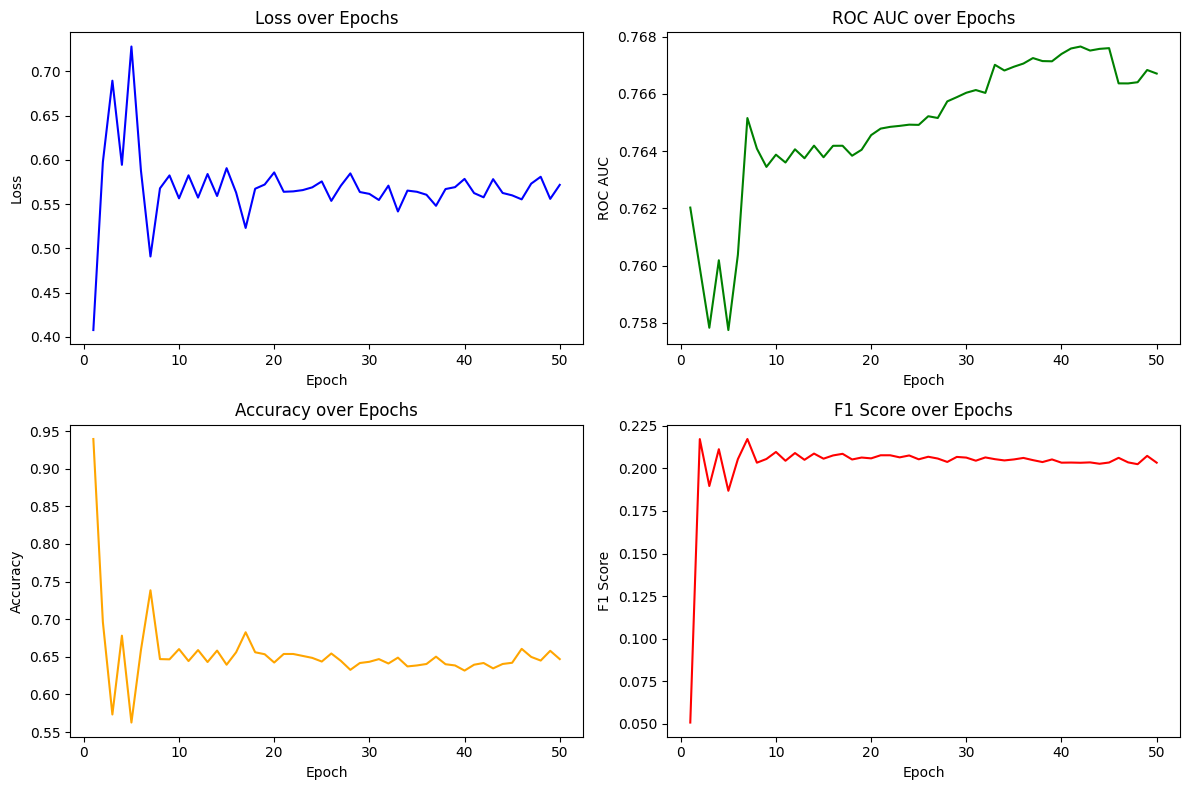

In [77]:
L_paill, ROC_AUC_paill, ACCURACY_paill, F1_paill = client_paill.losses, client_paill.ROC_AUCs, client_paill.ACCURACYs, client_paill.F1s
plot_metrics(L_paill, ROC_AUC_paill, ACCURACY_paill, F1_paill)

In [ ]:
L_paill_1, ROC_AUC_paill_1, ACCURACY_paill_1, F1_paill_1 = L_paill, ROC_AUC_paill, ACCURACY_paill, F1_paill  


In [78]:
L_fedavg == L_paill_1

False

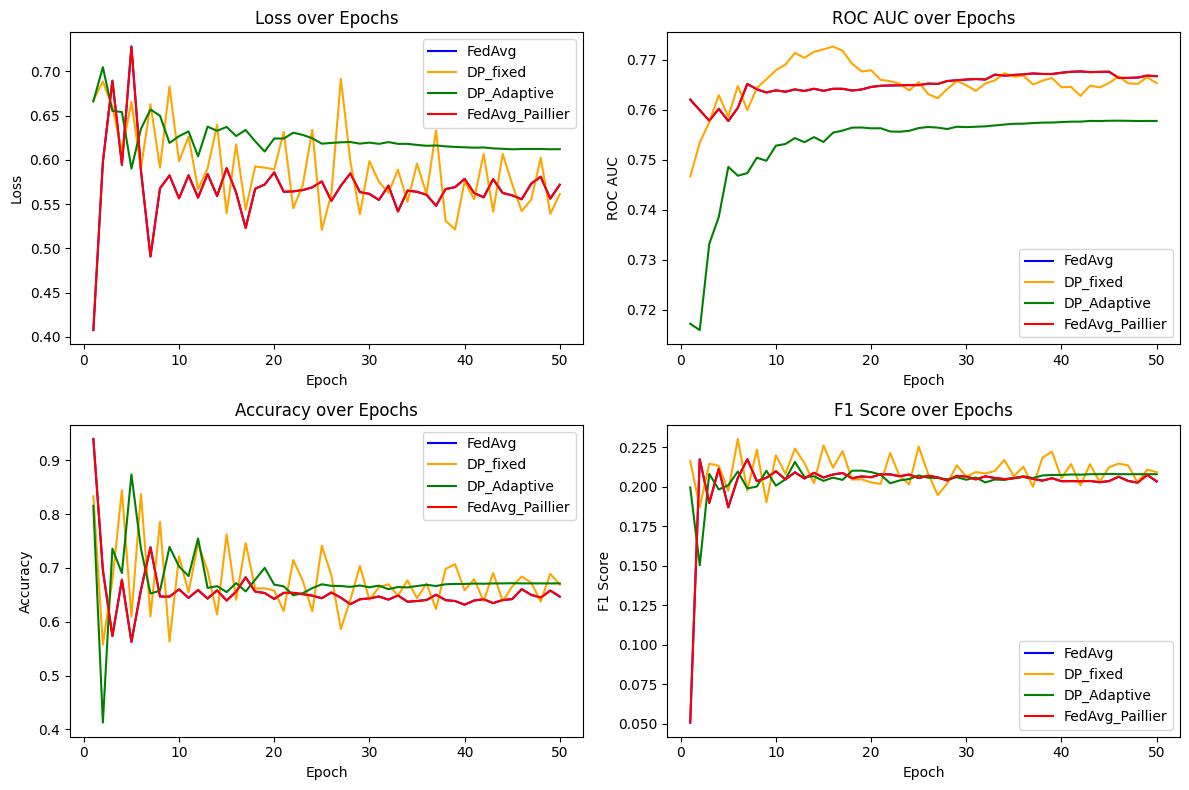

In [81]:
plot_metrics_comparison_simple(L_fedavg, ROC_AUC_fedavg, ACCURACY_fedavg, F1_fedavg,
                               L_dp_fixed, ROC_AUC_dp_fixed, ACCURACY_dp_fixed, F1_dp_fixed,
                               L_dp_adap, ROC_AUC_dp_adap, ACCURACY_dp_adap, F1_dp_adap,
                               L_paill_1, ROC_AUC_paill_1, ACCURACY_paill_1, F1_paill_1)

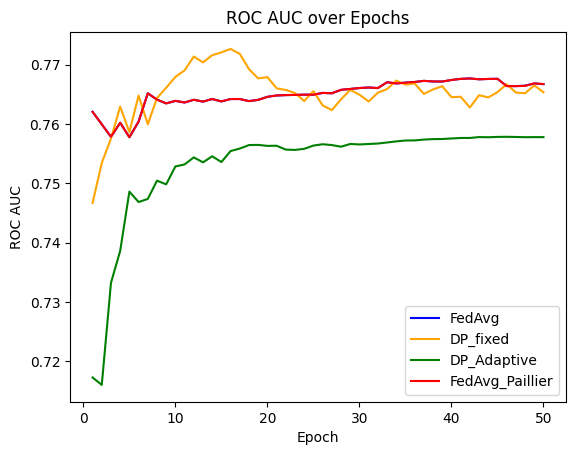

In [100]:
rounds = list(range(1, len(L_fedavg) + 1))


plt.plot(rounds, ROC_AUC_fedavg, color='blue', label='FedAvg')
plt.plot(rounds, ROC_AUC_dp_fixed, color='orange', label='DP_fixed')
plt.plot(rounds, ROC_AUC_dp_adap, color='green', label='DP_Adaptive')
plt.plot(rounds, ROC_AUC_paill, color='red', label='FedAvg_Paillier')
plt.title("ROC AUC over Epochs")
plt.xlabel("Epoch")
plt.ylabel("ROC AUC")
plt.legend()

In [98]:
fed_avg = np.array([ROC_AUC_fedavg]) 
paill = np.array([ROC_AUC_paill])

In [99]:
sum(fed_avg - paill)**2

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.65983719e-12, 0.00000000e+00, 3.65983719e-12,
       0.00000000e+00, 1.46393488e-11, 3.65983719e-12, 0.00000000e+00,
       0.00000000e+00, 1.46393488e-11, 1.46393488e-11, 1.05769295e-09,
       7.17328089e-10, 1.79332022e-10])